In [1]:
! which python

/Users/no_lineal/opt/anaconda3/envs/research36/bin/python


In [2]:
import pandas as pd
import numpy as np
import math

from scipy import signal
from scipy.integrate import simps

import mat73

from mne_features import univariate

from tqdm import tqdm

import os

# learning
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# viz
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
"""

    where am i?

"""

PATH = os.getcwd() + '/'
data_path = PATH + 'data/'

print(f'PATH: {PATH}')
print(f'data path: {data_path}')

PATH: /Users/no_lineal/Documents/GitHub/eeg_processing/
data path: /Users/no_lineal/Documents/GitHub/eeg_processing/data/


In [4]:
"""

    load data

"""

# signal
folder_name = 'LFP_conditions/'

# dorsal
d_cong = mat73.loadmat( data_path + folder_name + 'dcong.mat' )['dcong']
d_incong = mat73.loadmat( data_path + folder_name + 'dincg.mat' )['dincg']

In [5]:
"""

    dorsal trials

"""

d_cong_trial = sorted( [ x for x in d_cong.keys() if 'STN' in x ] )
d_incong_trial = sorted( [ x for x in d_incong.keys() if 'STN' in x ] )

trials = sorted(list(set(d_cong_trial).intersection( set(d_incong_trial) )))

print( f'd_cong_trial: {d_cong_trial}' )
print( f'd_incong_trial: {d_incong_trial}' )
print( f'trials: {trials}' )

d_cong_trial: ['STN02', 'STN03', 'STN07a', 'STN08', 'STN10a', 'STN10b', 'STN11', 'STN13']
d_incong_trial: ['STN02', 'STN07a', 'STN08', 'STN10a', 'STN10b', 'STN11', 'STN13']
trials: ['STN02', 'STN07a', 'STN08', 'STN10a', 'STN10b', 'STN11', 'STN13']


In [6]:
"""

    bandpower

"""

def band_power(signals, band, sf):
    
    columns_names = [
        'band_power',
        'total_power',
        'relative_power'
    ]
    
    feat = []
    
    for s in tqdm( range(signals.shape[0]) ):
        
        # drop nan
        tmp = signals[s]
        tmp = tmp[ ~np.isnan(tmp) ]
        
        # length
        len_ = len(tmp)
        
        # welch's periodogram
        win = math.ceil(2/band[0]) * sf
        freqs, psd = signal.welch(tmp, sf, nperseg=win)
        
        # power band
        low, high = band[0], band[1]
        idx = np.logical_and(freqs >= low, freqs <= high)
        freq_res = freqs[1] - freqs[0] # frequency resolution
        band_power = simps(psd[idx], dx=freq_res)
        total_power = simps(psd, dx=freq_res)
        relative_power = band_power / total_power
        
        feat.append( [band_power, total_power, relative_power] )
        
    return pd.DataFrame(feat, columns = columns_names)

In [7]:
"""

    signal features

"""

def comp_signal( signals ):
    
    columns_names = [
        'std',
        'mean', 
        'skewness', 
        'h_mobility',
        'h_complexity', 
        'length'
    ]
    
    feat = []
    
    for s in tqdm( range(signals.shape[0]) ):
        
        tmp = signals[s]
        tmp = tmp[ ~np.isnan(tmp) ]
        
        len_ = len(tmp)
        
        std = univariate.compute_std( tmp )
        
        if not std:
            std = 0.0
        
        mean = univariate.compute_mean( tmp )
        
        skw = univariate.compute_skewness( tmp )
        
        h_mob = univariate.compute_hjorth_mobility( tmp )
        
        if math.isnan( h_mob ):
            h_mob = 0.0
        
        h_comp = univariate.compute_hjorth_complexity( tmp )
        
        if math.isnan( h_comp ):
            h_comp = 0.0
        
        feat.append( [std, mean, skw, h_mob, h_comp, len_] )
        
    return pd.DataFrame(feat, columns = columns_names)

In [8]:
"""

    signals

"""

# response
cue_type = 'sigcue'

# sampling frequency
sf = 1000

for x in ['STN08']:
#for x in ['STN10b']:
    
    cue_cong = d_cong[ x ][ cue_type ][0][ 'dCong_trl' ]
    cue_incong = d_incong[ x ][ cue_type ][0][ 'dIncg_trl' ]
    
    print(x)
    print(f'cue cong shape: {cue_cong.shape}')
    print(f'cue incong shape: {cue_incong.shape}')
    print('\n')
    
    # congruent
    delta_cong = band_power( cue_cong, [0.5, 4.0], sf ).rename(columns={'band_power': 'delta_power', 'relative_power': 'delta_relative_power'})
    theta_cong = band_power( cue_cong, [4.0, 8.0], sf ).rename(columns={'band_power': 'theta_power', 'relative_power': 'theta_relative_power'})
    alpha_cong = band_power( cue_cong, [8.0, 12.0], sf ).rename(columns={'band_power': 'alpha_power', 'relative_power': 'alpha_relative_power'})
    beta_cong = band_power( cue_cong, [12.0, 30.0], sf ).rename(columns={'band_power': 'beta_power', 'relative_power': 'beta_relative_power'})
    gamma_cong = band_power( cue_cong, [30.0, 100.0], sf ).rename(columns={'band_power': 'gamma_power', 'relative_power': 'gamma_relative_power'})
    
    power_band_cong = pd.concat(
        [
            delta_cong[['delta_power']],
            theta_cong[['theta_power']],
            alpha_cong[['alpha_power']],
            beta_cong[['beta_power']], 
            gamma_cong[['gamma_power']]
        ], axis=1
    )
    
    # incongruent
    delta_incg = band_power( cue_incong, [0.5, 4.0], sf ).rename(columns={'band_power': 'delta_power', 'relative_power': 'delta_relative_power'})
    theta_ing = band_power( cue_incong, [4.0, 8.0], sf ).rename(columns={'band_power': 'theta_power', 'relative_power': 'theta_relative_power'})
    alpha_incg = band_power( cue_incong, [8.0, 12.0], sf ).rename(columns={'band_power': 'alpha_power', 'relative_power': 'alpha_relative_power'})
    beta_incg = band_power( cue_incong, [12.0, 30.0], sf ).rename(columns={'band_power': 'beta_power', 'relative_power': 'beta_relative_power'})
    gamma_incg = band_power( cue_incong, [30.0, 100.0], sf ).rename(columns={'band_power': 'gamma_power', 'relative_power': 'gamma_relative_power'})
    
    power_band_incg = pd.concat(
        [
            delta_incg[['delta_power']],
            theta_ing[['theta_power']],
            alpha_incg[['alpha_power']],
            beta_incg[['beta_power']], 
            gamma_incg[['gamma_power']]
        ], axis=1
    )
    
    feat_cong = comp_signal( cue_cong )
    feat_incg = comp_signal( cue_incong )

    power_band_cong = pd.concat([power_band_cong, feat_cong], axis=1)
    power_band_incg = pd.concat([power_band_incg, feat_incg], axis=1)
    
    print(f'features cong: {power_band_cong.shape}')
    print(f'features incg: {power_band_incg.shape}')
    print('\n')
    
    
    # label of events
    power_band_cong['label'] = 0
    power_band_incg['label'] = 1
    
    data = pd.concat( [power_band_cong, power_band_incg] )

    print(f'data: {data.shape}')

STN08
cue cong shape: (154, 2313)
cue incong shape: (162, 2098)




100%|██████████| 162/162 [00:00<00:00, 3682.09it/s]

features cong: (154, 11)
features incg: (162, 11)


data: (316, 12)


In [9]:
"""

    data and balance

"""

#data = data.sample(frac=1).reset_index()

print( data.info() )
print( data['label'].value_counts(normalize=True) )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316 entries, 0 to 161
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   delta_power   316 non-null    float64
 1   theta_power   316 non-null    float64
 2   alpha_power   316 non-null    float64
 3   beta_power    316 non-null    float64
 4   gamma_power   316 non-null    float64
 5   std           316 non-null    float64
 6   mean          316 non-null    float64
 7   skewness      316 non-null    float64
 8   h_mobility    316 non-null    float64
 9   h_complexity  316 non-null    float64
 10  length        316 non-null    int64  
 11  label         316 non-null    int64  
dtypes: float64(10), int64(2)
memory usage: 32.1 KB
None
1    0.512658
0    0.487342
Name: label, dtype: float64


<AxesSubplot:>

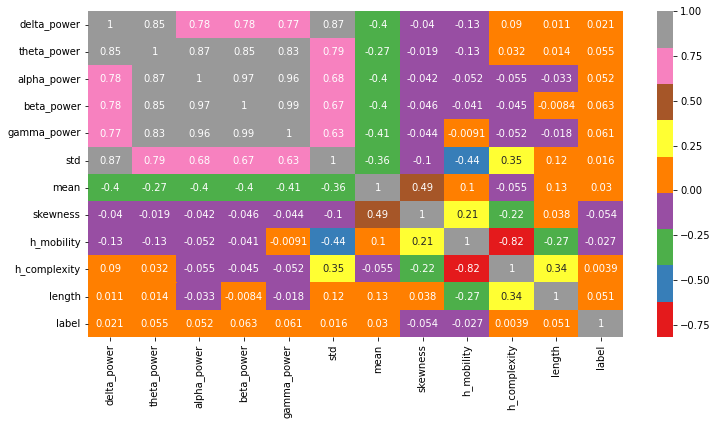

In [10]:
"""

    correlation 

"""

cor = data.corr()
plt.figure(figsize=(12,6))
sns.heatmap(cor, cmap='Set1', annot=True)

In [11]:
"""

    input

"""

features = [ x for x in list(data) if x not in ['label', 'length', 'std', 'mean', 'skewness', 'h_mobility', 'h_complexity'] ]

print(f'features: {features}')

label = [
    'label'
]

X = data[ features ]
y = data[ label ]

features: ['delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power']


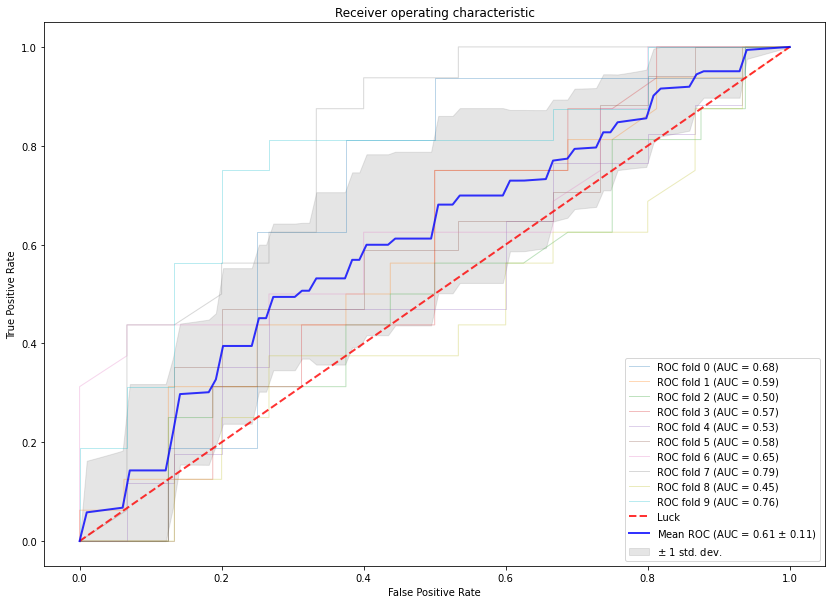

   AUC Train  AUC Test
0   0.987741  0.675781
1   0.993523  0.593750
2   0.985482  0.498047
3   0.991984  0.568359
4   0.992607  0.525490
5   0.990871  0.584314
6   0.993027  0.650000
7   0.987977  0.791667
8   0.988814  0.447917
9   0.994112  0.762500


In [12]:
"""

    training

"""

def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

clf = RandomForestClassifier(
    n_estimators=10,
    criterion='gini',
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='log2',
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

n = 10

cv = StratifiedKFold(n_splits=n, random_state=42, shuffle=True)

for clf in [clf]:
    
    results = pd.DataFrame(columns=['training_score', 'test_score'])
    fprs, tprs, scores = [], [], []

    for (train, test), i in zip(cv.split(X, y), range(n)):
    
        clf.fit(X.iloc[train], y.iloc[train])
    
        _, _, auc_score_train = compute_roc_auc(train)
        fpr, tpr, auc_score = compute_roc_auc(test)
    
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
    
    plot_roc_curve(fprs, tprs);
    print(pd.DataFrame(scores, columns=['AUC Train', 'AUC Test']))